In [1]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])


In [2]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)



df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,4,7,Married-civ-spouse,1,Husband,0,0,0,45,0
1,3,10,Married-civ-spouse,0,Husband,0,0,0,40,1
2,3,9,Divorced,1,Not-in-family,0,0,0,65,0
3,2,14,Married-civ-spouse,0,Husband,0,0,0,50,1
4,1,10,Never-married,0,Not-in-family,1,0,0,25,0
...,...,...,...,...,...,...,...,...,...,...
48837,1,9,Never-married,1,Own-child,1,0,0,40,0
48838,4,6,Married-civ-spouse,0,Wife,1,0,0,36,0
48839,2,9,Married-civ-spouse,1,Husband,0,0,0,40,1
48840,1,12,Married-civ-spouse,0,Wife,1,0,0,40,0


In [3]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

In [4]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [5]:
#Importing necessary modules
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
#Defining our model 
model = LogisticRegression()

#Initialising scaler
scaler = StandardScaler()

#For logistic regresion, need to scale our data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#Need to transform our y data as
y_train = y_train.ravel()
Y_test = y_test.ravel()

#Define all of our hyperparameters 
solvers = ['newton-cg', 'liblinear', 'lbfgs','newton-cholesky', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet']
c_values = [1000, 10, 1, 0.1, 0.001, 0.001]

#Defining our search space 
space = dict(solver = solvers, penalty = penalty, C = c_values)

#Defining our cross validation
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

#Initialising our grid search
grid_search = GridSearchCV(estimator = model, param_grid = space, n_jobs = -1,cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Best: 0.842432 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'newton-cg'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'newton-cholesky'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'sag'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l1', 'solver': 'saga'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cholesky'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l2', 'solver': 'sag'}
0.842312 (0.004756) with: {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (

In [6]:
#Testing results for optimal hyperparameter combination, with scaled vs unscaled data 

model = LogisticRegression(solver = grid_result.best_params_['solver'], penalty = grid_result.best_params_['penalty'], C = grid_result.best_params_['C'])

model.fit(X_train_scaled, y_train)

train_acc_scaled = model.score(X_train_scaled, y_train)

print('Accuracy for scaled date: ', train_acc_scaled)

model.fit(X_train, y_train)

train_acc = model.score(X_train, y_train)

print('Accuracy for unscaled data: ', train_acc)

Accuracy for scaled date:  0.8424136882549687
Accuracy for unscaled data:  0.8424413301268762


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [7]:
#Importing necessary libraries 
from sklearn.decomposition import PCA

#Want to use datasets of different dimensions 

model = LogisticRegression(solver = grid_result.best_params_['solver'], penalty = grid_result.best_params_['penalty'], C = grid_result.best_params_['C'])

model.fit(X_train_scaled, y_train)

original_acc = model.score(X_train_scaled, y_train)

print(X_train_scaled.shape)

#From above, we get that dimension of X_train_scaled is 36177x20

#Want to use PCA to reduce to 15, 10 and 5 and see if that has any effect 
pca = PCA(n_components=15)
X_train_15 = pca.fit_transform(X_train_scaled)
model.fit(X_train_15, y_train)
acc_15 = model.score(X_train_15, y_train)

pca = PCA(n_components=10)
X_train_10 = pca.fit_transform(X_train_scaled)
model.fit(X_train_10, y_train)
acc_10 = model.score(X_train_10, y_train)

pca = PCA(n_components=5)
X_train_5 = pca.fit_transform(X_train_scaled)
model.fit(X_train_5, y_train)
acc_5 = model.score(X_train_5, y_train)


print('Original accuracy: ', original_acc)
print('Accuracy for data reduced to 15 dimensions: ', acc_15)
print('Accuracy for data reduced to 10 dimensions: ', acc_10)
print('Accuracy for data reduced to 5 dimensions: ', acc_5)

(36177, 20)
Original accuracy:  0.8424136882549687
Accuracy for data reduced to 15 dimensions:  0.8422478370235232
Accuracy for data reduced to 10 dimensions:  0.8296984271774884
Accuracy for data reduced to 5 dimensions:  0.8287033197888161


In [8]:
#From above, can see that the dimensionality reduction doesn't have much of an effect on overall accuracy
#From results above, can see that errors are generated for many of the cases. This means that for that particular 'solver', convergence isn't acheived
#Optimal set of hyperparameters is generated 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X =

0.8426901069740442
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     27150
           1       0.73      0.59      0.65      9027

    accuracy                           0.84     36177
   macro avg       0.80      0.76      0.77     36177
weighted avg       0.84      0.84      0.84     36177



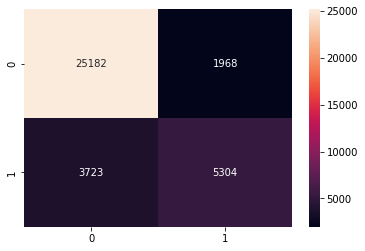

In [14]:
#Getting final evaluation metrics for Logistic Regression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

model = LogisticRegression(solver = grid_result.best_params_['solver'], penalty = grid_result.best_params_['penalty'], C = grid_result.best_params_['C'])

#Fitting the optimal version of our model
model.fit(X_train_scaled, y_train.ravel())

#Getting predictions
train_data_predictions = cross_val_predict(model, X_train, y_train.ravel(), cv=20)

print(accuracy_score(y_train, train_data_predictions))

#Getting confusion matrix 
confusion_matrix(y_train, train_data_predictions)
classes_names = ['class 1','class 2','class 3', 'class 4']
cm = pd.DataFrame(confusion_matrix(y_train, train_data_predictions))
print(sns.heatmap(cm, annot=True, fmt='d'))
print(classification_report(y_train, train_data_predictions))